## 🎯 Objectif du projet : Inférence variationnelle stochastique pour LDA

Cette section détaille le **projet d’application de l’article** *Stochastic Variational Inference*, en l'appliquant au modèle de **Latent Dirichlet Allocation (LDA)** pour l’analyse thématique de documents.

---

## 🔁 Contexte : LDA comme modèle génératif

Le modèle LDA repose sur un **processus génératif** :

1. Chaque document est associé à une **distribution sur les sujets** $ \theta_d \sim \text{Dirichlet}(\alpha) $
2. Chaque sujet $ k $ est associé à une **distribution de mots** $ \beta_k \sim \text{Dirichlet}(\eta) $
3. Pour chaque mot dans un document :
   - Tirer un sujet $ z_{dn} \sim \text{Categorical}(\theta_d) $
   - Tirer un mot $ w_{dn} \sim \text{Categorical}(\beta_{z_{dn}}) $

---

## 🎯 Objectif inverse : inférer les sujets cachés à partir des mots observés

L'inférence variationnelle stochastique (SVI) cherche à **inverser ce processus** :

- À partir d’un corpus de documents $ w $, retrouver :
  - Les **topics** $ \beta_k $
  - Les **distributions de sujets** $ \theta_d $
  - Les **affectations de sujets par mot** $ z_{dn} $ (optionnel)

---

## 🧠 Cibles formelles de l’inférence

1. **Apprendre la distribution des topics sur les mots :**
   $$
   \beta_k \approx \text{distribution de probabilité sur les mots pour chaque topic } k
   $$

2. **Apprendre la distribution des topics dans chaque document :**
   $$
   \theta_d \approx \text{proportion de chaque topic dans le document } d
   $$

3. *(Optionnel)* **Inférer les topics associés à chaque mot :**
   $$
   z_{dn} \in \{1, \dots, K\} \text{ pour chaque mot } n \text{ du document } d
   $$

---

## 📊 Résultats attendus du modèle SVI + LDA

### 📜 1. Liste de topics interprétables

Topic 1: roi, guerre, traité, royaume, empereur

Topic 2: musée, peinture, artiste, sculpture, œuvre

Topic 3: climat, région, océan, tempête, mois

Document 17 : « Napoléon »

→ 70% histoire, 20% politique, 10% géographie


Document 42 : « Impressionnisme »

→ 80% art, 15% histoire, 5% géographie

### 🗂️ 3. Structure sémantique du corpus

- Regroupement automatique des documents par thème
- Visualisation des distances sémantiques
- Recommandations de lectures similaires

---

## 🧩 Ce que l’algorithme SVI fait réellement

- Approximation variationnelle de $ p(\theta, z \mid w) $
- Optimisation de l’ELBO par **mini-batchs**
- Algorithme **scalable** à des millions de documents

---

## ✅ Résumé des sorties attendues

| Élément                  | Description                                        |
|--------------------------|----------------------------------------------------|
| Modèle entraîné          | LDA avec SVI pour inférence rapide                 |
| Données                  | Corpus Wikipedia                                   |
| Résultats attendus       | Topics interprétables, proportions par document    |
| Possibles extensions     | LDA supervisé, topics dynamiques, visualisations   |

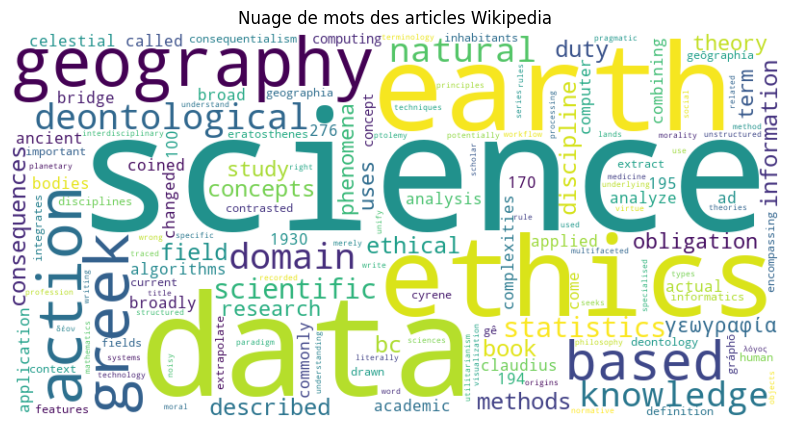

In [36]:
import wikipedia
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Choix des sujets Wikipedia à extraire
topics = ["geography", "data science", "deontology"]

# Récupération des résumés Wikipedia
documents = []
for topic in topics:
    try:
        summary = wikipedia.summary(topic, sentences=5)  # Récupère 5 phrases
        documents.append(summary)
    except Exception as e:
        print(f"Erreur pour le sujet {topic}: {e}")
        documents.append("")

# Vectorisation des textes
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(documents)

# Extraction du vocabulaire
vocab = vectorizer.get_feature_names_out()
docs_indices = [X[i].nonzero()[1].tolist() for i in range(len(documents))]

# Affichage d’un nuage de mots (optionnel)
word_freq = np.asarray(X.sum(axis=0)).flatten()
word_freq_dict = dict(zip(vocab, word_freq))

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq_dict)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Nuage de mots des articles Wikipedia")
plt.show()

In [37]:
# SVI training (à faire AVANT le code des topics)
K = 3  # nombre de topics
alpha = np.ones(K)
eta = np.ones(len(vocab))
tau = 1.0
kappa = 0.7

# Initialisation
beta = np.random.dirichlet(eta, K)
lambda_t = beta.copy()

def learning_rate(t, tau=1.0, kappa=0.7):
    return (t + tau) ** (-kappa)

def svi_update(doc_words_idx, lambda_old, t):
    N = len(doc_words_idx)
    phi = np.ones((N, K)) / K
    gamma = alpha + N / K
    for _ in range(5):
        for n, w in enumerate(doc_words_idx):
            phi[n] = beta[:, w] * np.exp(np.log(gamma))
            phi[n] /= np.sum(phi[n])
        gamma = alpha + np.sum(phi, axis=0)
    lambda_hat = np.zeros_like(beta)
    for n, w in enumerate(doc_words_idx):
        lambda_hat[:, w] += phi[n]
    lambda_hat *= len(docs_indices)
    rho_t = learning_rate(t)
    lambda_new = (1 - rho_t) * lambda_old + rho_t * lambda_hat
    return lambda_new, phi, gamma

lambda_current = lambda_t.copy()
for t in range(10):
    d = np.random.randint(0, len(docs_indices))
    doc = docs_indices[d]
    lambda_current, phi, gamma = svi_update(doc, lambda_current, t)

,Topic,Top Words
0,Geography,"greek, study, used, rule, theory"
1,Data Science,"term, wrong, broad, consequences, specialised"
2,Deontology,"utilitarianism, philosophy, contrasted, pragma..."


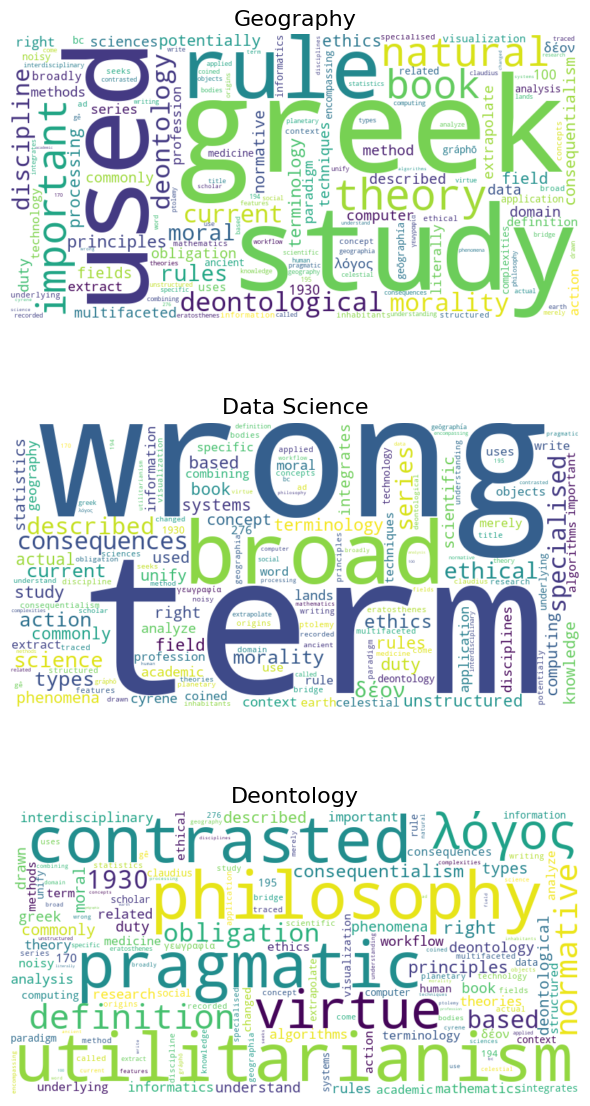

,Geography,Data Science,Deontology
Doc 1,0.393722,0.534281,0.071997
Doc 2,0.434169,0.293753,0.272077
Doc 3,0.264738,0.304018,0.431244


In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# -----------------------
# Associer les noms de topics aux lignes de la matrice
# -----------------------
topic_names = [topic.replace("_", " ").title() for topic in topics]  # propre
df_topics = pd.DataFrame(lambda_current, columns=vocab, index=topic_names)

# -----------------------
# 1. Afficher les top mots par topic
# -----------------------
def get_top_words_per_topic(df, top_n=5):
    top_words = {}
    for topic_name, row in df.iterrows():
        top_words[topic_name] = row.sort_values(ascending=False).head(top_n).index.tolist()
    return pd.DataFrame([
        {"Topic": topic, "Top Words": ", ".join(words)}
        for topic, words in top_words.items()
    ])

df_top_words = get_top_words_per_topic(df_topics, top_n=5)
display(df_top_words)

# -----------------------
# 2. Générer les WordClouds pour chaque topic
# -----------------------
def plot_wordclouds_for_topics(df, n_cols=1):
    n_topics = df.shape[0]
    fig, axs = plt.subplots(n_topics, n_cols, figsize=(6 * n_cols, 4 * n_topics))
    if n_topics == 1:
        axs = [axs]

    for i, (topic_name, word_weights) in enumerate(df.iterrows()):
        word_freq = word_weights.to_dict()
        wc = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

        ax = axs[i] if n_topics > 1 else axs[0]
        ax.imshow(wc, interpolation='bilinear')
        ax.axis("off")
        ax.set_title(topic_name, fontsize=16)

    plt.tight_layout()
    plt.show()

plot_wordclouds_for_topics(df_topics)

# -----------------------
# 3. Matrice de proportion de topics par document (θ_d)
# -----------------------
def compute_theta_matrix(docs_indices, lambda_topics, alpha):
    D = len(docs_indices)
    K = lambda_topics.shape[0]
    theta = np.zeros((D, K))

    for d, doc in enumerate(docs_indices):
        phi = np.ones((len(doc), K)) / K
        gamma = alpha + len(doc) / K

        for _ in range(5):
            for n, w in enumerate(doc):
                phi[n] = lambda_topics[:, w] * np.exp(np.log(gamma))
                phi[n] /= np.sum(phi[n])
            gamma = alpha + np.sum(phi, axis=0)

        theta[d, :] = gamma / np.sum(gamma)

    return pd.DataFrame(theta, columns=topic_names,
                        index=[f"Doc {i+1}" for i in range(D)])

df_theta = compute_theta_matrix(docs_indices, lambda_current, alpha)
display(df_theta)